In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

from underactuated import FindResource
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
from pydrake.all import (AddMultibodyPlantSceneGraph,
                         DirectCollocation, 
                         DiagramBuilder,
                         FiniteHorizonLinearQuadraticRegulatorOptions, 
                         LinearQuadraticRegulator, 
                         LogOutput,
                         MakeFiniteHorizonLinearQuadraticRegulator,
                         MultibodyPlant, 
                         MultibodyPositionToGeometryPose,
                         Parser,
                         PiecewisePolynomial,
                         PlanarSceneGraphVisualizer, 
                         SceneGraph, 
                         Simulator,
                         Solve, 
                         SymbolicVectorSystem, 
                         TrajectorySource,
                         Variable, 
                         VectorSystem, 
                         cos, sin)


from ballbot import make_robot

plt_is_interactive = SetupMatplotlibBackend()

# 2D Ballbot Direct Collocation

<IPython.core.display.Javascript object>


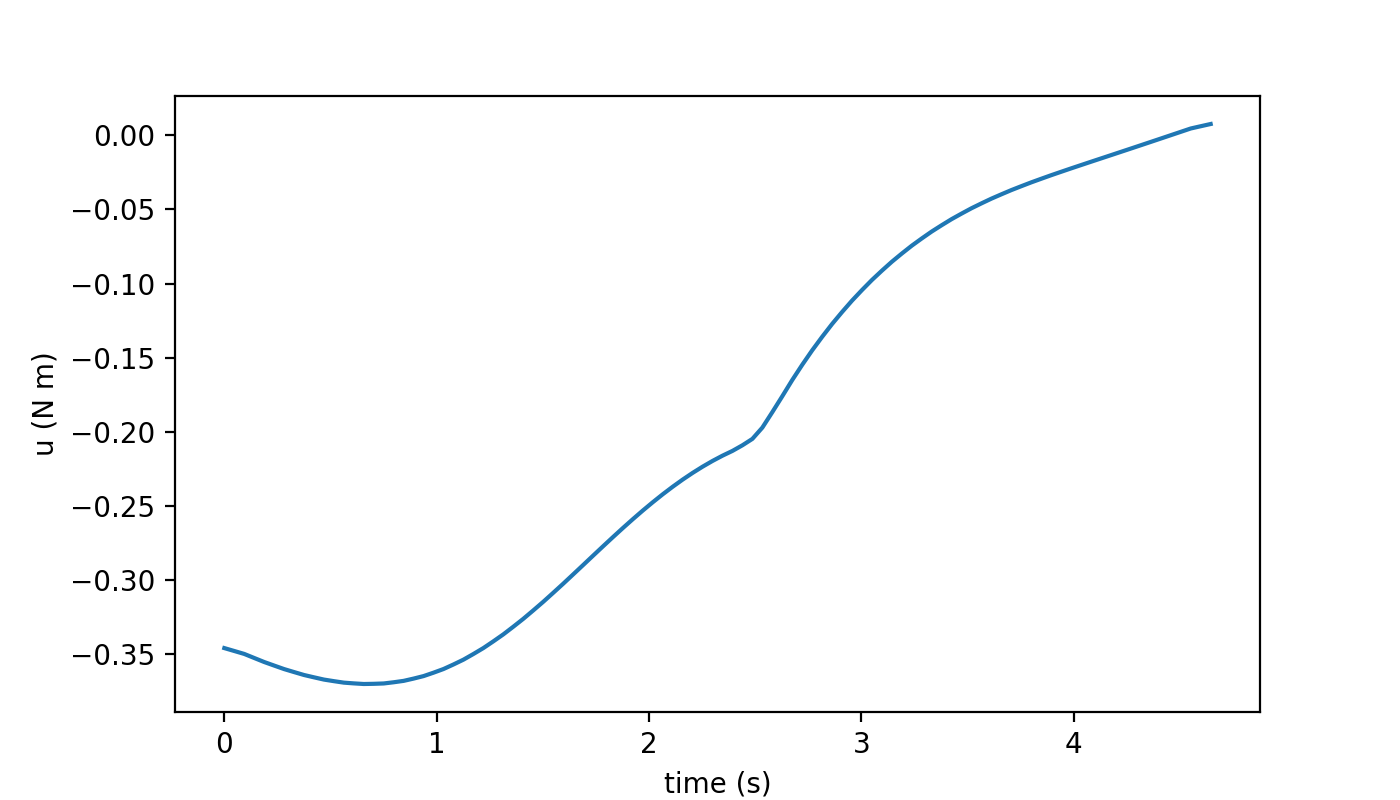

<IPython.core.display.Javascript object>


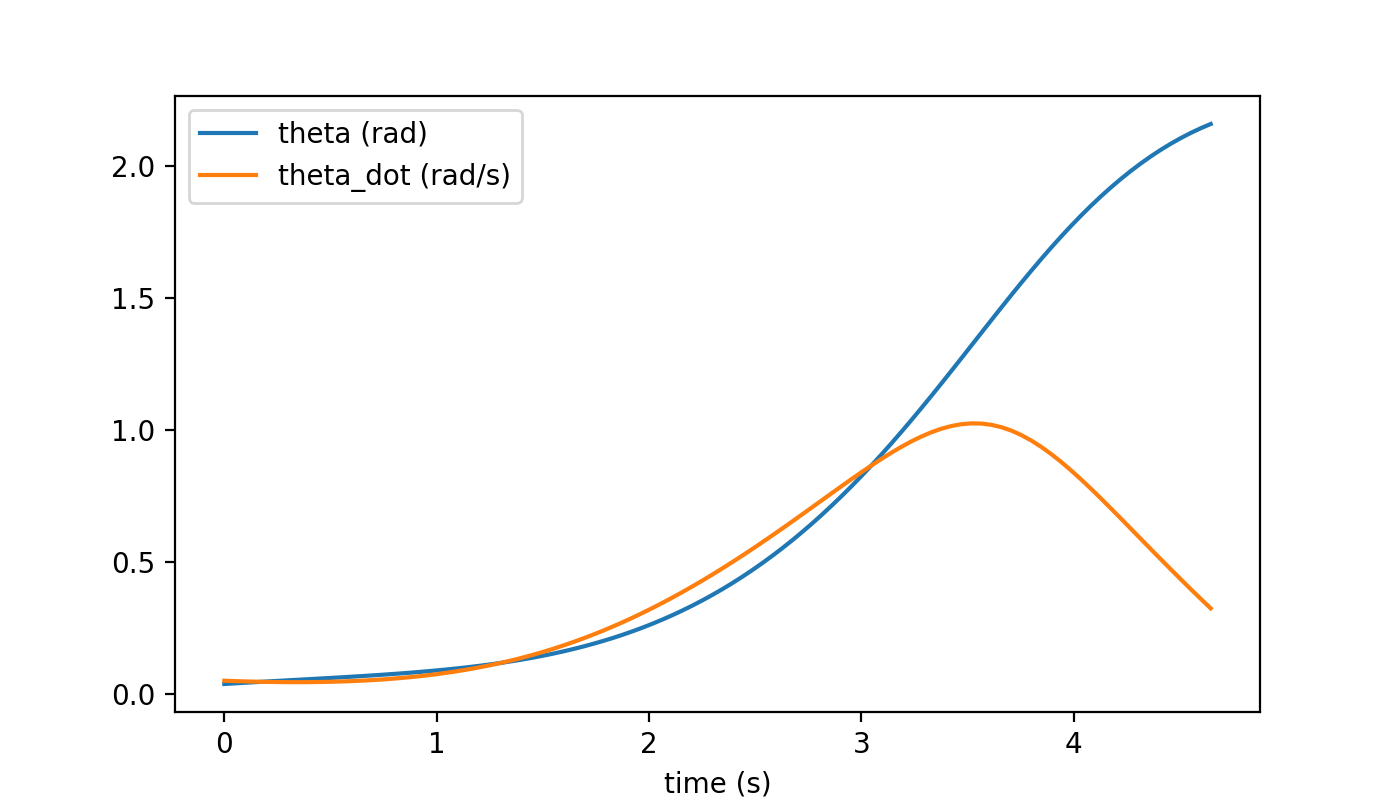

<IPython.core.display.Javascript object>


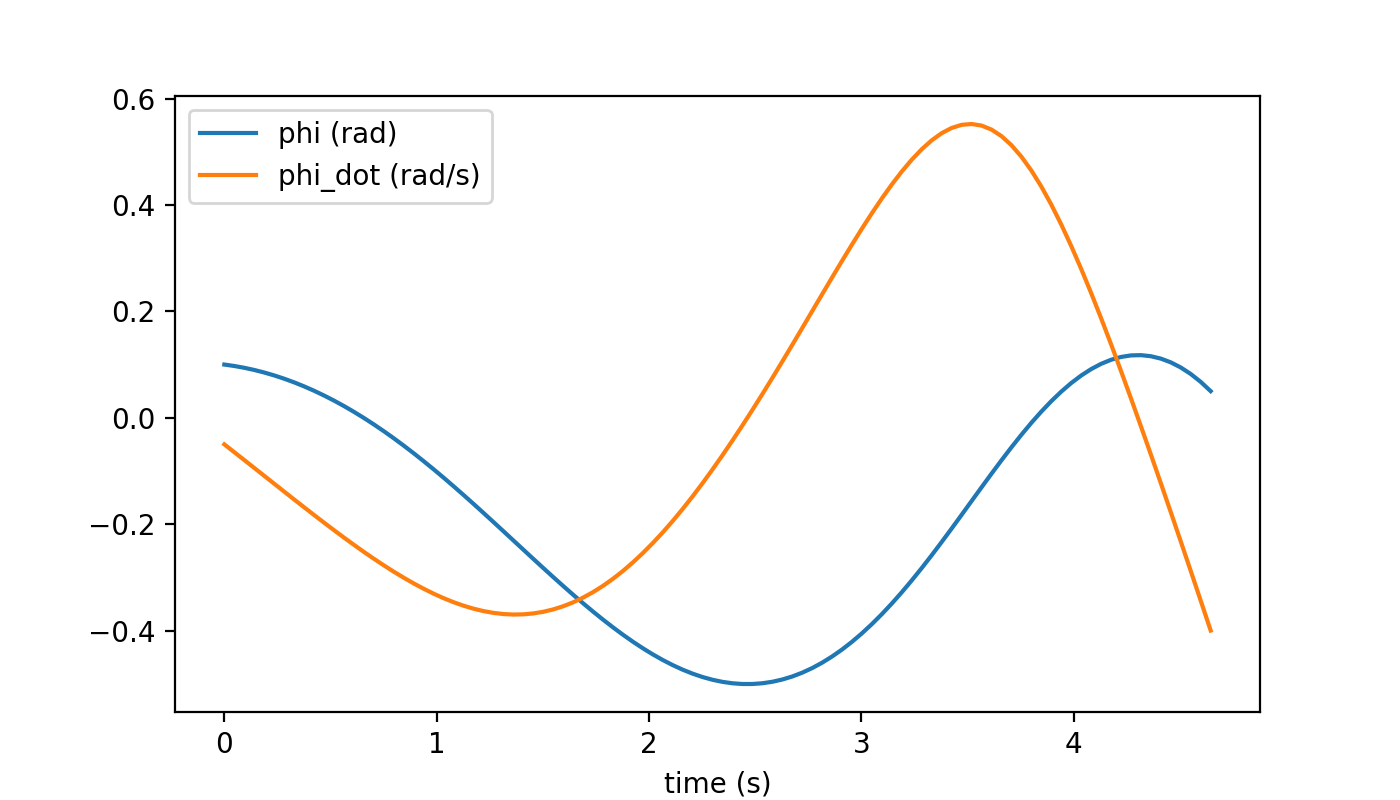

In [2]:
plant = make_robot()
context = plant.CreateDefaultContext()
samples = 51
dircol = DirectCollocation(plant,
                           context,
                           num_time_samples=samples,
                           minimum_timestep=0.05,
                           maximum_timestep=0.4)

dircol.AddEqualTimeIntervalsConstraints()

# Add input limits.
torque_limit = 1# N*m.
u = dircol.input()
dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

initial_state_lb = (-.1, -.1, -.05, -.05)
initial_state_ub = (0.1, 0.1, 0.05, 0.05)
dircol.AddBoundingBoxConstraint(initial_state_lb, initial_state_ub,
                                dircol.initial_state())
# More elegant version is blocked on drake #8315:
# dircol.AddBoundingBoxConstraint(.05, .1, dircol.state(10)[1])
# dircol.AddBoundingBoxConstraint(-.1, .0, dircol.state(10)[0])

for t in range(samples):
    dircol.AddBoundingBoxConstraint(-.5, .5, dircol.state(t)[1])

final_state_lb = (2., -.05, -.4, -.4)
final_state_ub = (3., 0.05, 0.4, 0.4)
dircol.AddBoundingBoxConstraint(final_state_lb, final_state_ub, dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state)

# R = np.diag([100, 10])  # Cost on input "effort".
# dircol.AddRunningCost(np.array([u[0], dircol.state()[1]]).T.dot(R).dot(np.array([u[0], dircol.state()[1]])))
R = 100
dircol.AddRunningCost(R * u[0]**2)
# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time()**2)

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state_lb, final_state_lb)))  # yapf: disable
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert (result.is_success())

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

x_trajectory = dircol.ReconstructStateTrajectory(result)
times = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
x_lookup = np.vectorize(x_trajectory.value)
phi_values = [x_trajectory.value(t)[0] for t in times]
nu_values = [x_trajectory.value(t)[1] for t in times]
phi_dot_values = [x_trajectory.value(t)[2] for t in times]
nu_dot_values = [x_trajectory.value(t)[3] for t in times]

plt.figure(figsize=(7, 4))
plt.plot(times, u_values)
plt.xlabel("time (s)")
plt.ylabel("u (N m)")
# plt.savefig("dircol_input.svg")

plt.figure(figsize=(7, 4))
plt.plot(times, phi_values)
plt.plot(times, phi_dot_values)
plt.xlabel("time (s)")
plt.legend(('theta (rad)','theta_dot (rad/s)'))
# plt.savefig("dircol_theta.svg")

plt.figure(figsize=(7, 4))
plt.plot(times, nu_values)
plt.plot(times, nu_dot_values)
plt.xlabel("time (s)")
plt.legend(('phi (rad)','phi_dot (rad/s)'))
# plt.savefig("dircol_phi.svg")

<IPython.core.display.Javascript object>


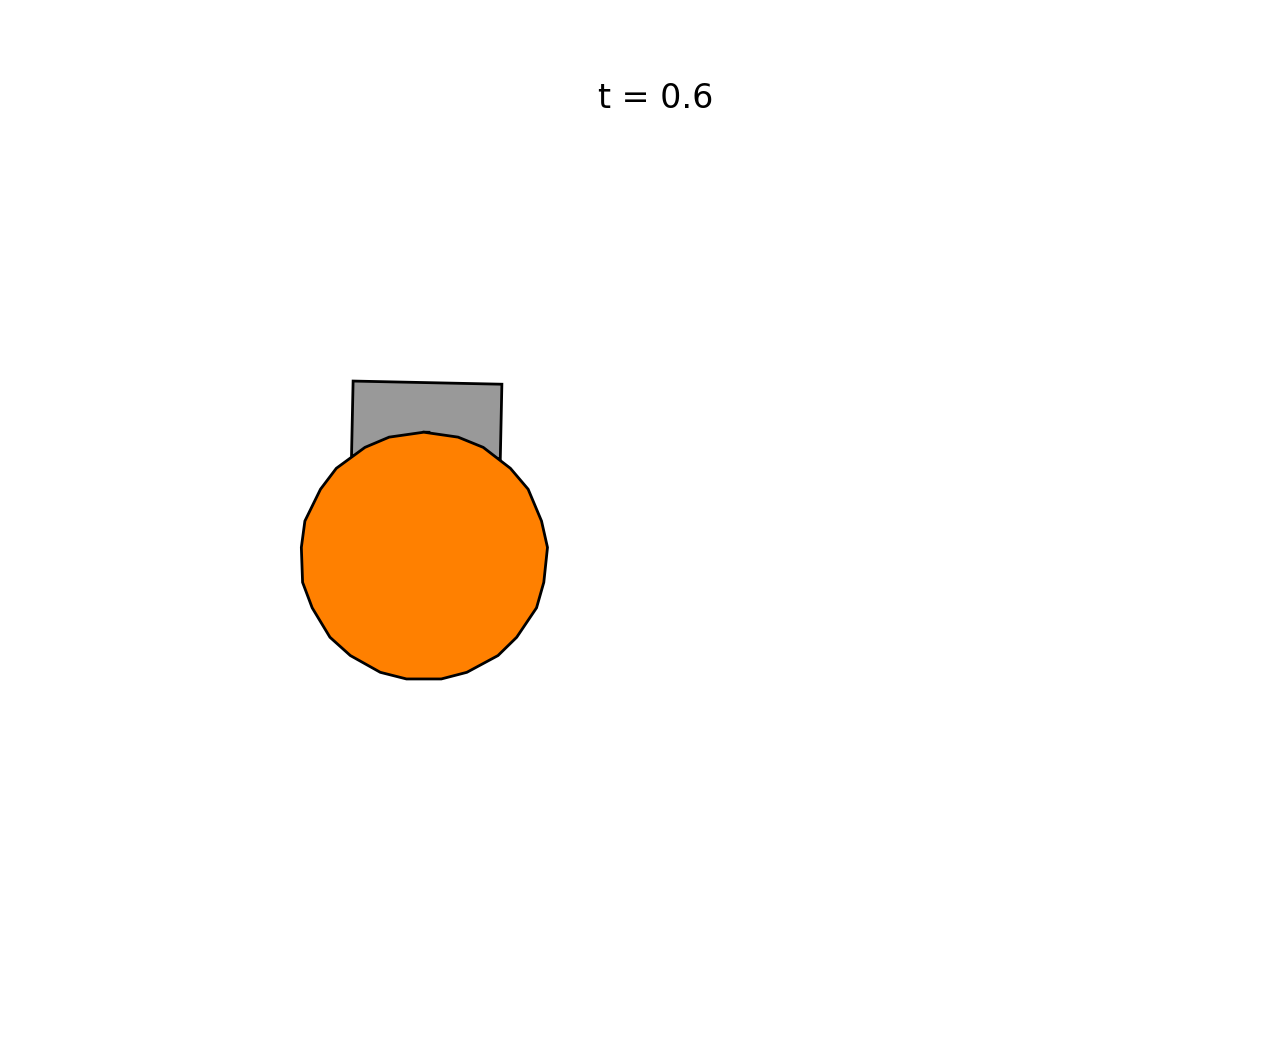

In [3]:
x_trajectory = dircol.ReconstructStateTrajectory(result)

urdf_plant = MultibodyPlant(time_step=0.0)
scene_graph = SceneGraph()
urdf_plant.RegisterAsSourceForSceneGraph(scene_graph)
file_name = FindResource("models/planar_ballbot.urdf")
Parser(urdf_plant).AddModelFromFile(file_name)
urdf_plant.Finalize()

builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(
    MultibodyPositionToGeometryPose(urdf_plant, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(),
                scene_graph.get_source_pose_port(urdf_plant.get_source_id()))

visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph,
                               xlim=[-1, 3],
                               ylim=[-1.25, 2],
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
simulator = Simulator(builder.Build())
visualizer.start_recording()
AdvanceToAndVisualize(simulator, visualizer, x_trajectory.end_time())
visualizer.stop_recording()

In [4]:
# construct animation
ani = visualizer.get_recording_as_animation()

# display animation below the cell
display(HTML(ani.to_jshtml()))
from matplotlib import animation
writer = animation.writers['ffmpeg'](fps=30, bitrate=1800)
# ani.save('dircol.mp4', writer=writer)